In [26]:
from tqdm.auto import tqdm

In [27]:
from google.colab import drive
drive.mount('/content/drive')

import os, random, copy, time, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
GPU: Tesla T4


In [28]:
DATA_DIR = "/content/drive/MyDrive/dl_project/data_processed_pre_covid"
WS = 24

X_train = np.load(os.path.join(DATA_DIR, f"X_train_ws{WS}.npy"))
y_train = np.load(os.path.join(DATA_DIR, f"y_train_ws{WS}.npy"))
X_val   = np.load(os.path.join(DATA_DIR, f"X_val_ws{WS}.npy"))
y_val   = np.load(os.path.join(DATA_DIR, f"y_val_ws{WS}.npy"))
X_test  = np.load(os.path.join(DATA_DIR, f"X_test_ws{WS}.npy"))
y_test  = np.load(os.path.join(DATA_DIR, f"y_test_ws{WS}.npy"))

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (125781, 24, 66) (125781,)
Val:   (26953, 24, 66) (26953,)
Test:  (26954, 24, 66) (26954,)


In [29]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled   = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_val_t   = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_t   = torch.tensor(y_val_scaled, dtype=torch.float32).to(device)
X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=BATCH_SIZE, shuffle=False)

xb, yb = next(iter(train_loader))
print("Batch X:", xb.shape, "Batch y:", yb.shape)

Batch X: torch.Size([64, 24, 66]) Batch y: torch.Size([64])


In [30]:
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred, eps=1e-6):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + eps))) * 100

@torch.no_grad()
def evaluate_model_scaled(model, loader):
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        pred = model(xb)
        ys.append(yb)
        ps.append(pred)
    y_true = torch.cat(ys)
    y_pred = torch.cat(ps)
    return {
        "MAPE": mape(y_true, y_pred).item(),
        "MAE": mae(y_true, y_pred).item(),
        "RMSE": rmse(y_true, y_pred).item()
    }

@torch.no_grad()
def evaluate_model_original_units(model, loader, scaler_y):
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        pred = model(xb)
        ys.append(yb.detach().cpu().numpy())
        ps.append(pred.detach().cpu().numpy())
    y_true_s = np.concatenate(ys)
    y_pred_s = np.concatenate(ps)

    y_true = scaler_y.inverse_transform(y_true_s.reshape(-1, 1)).ravel()
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).ravel()

    eps = 1e-6
    mape_v = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0
    mae_v  = np.mean(np.abs(y_true - y_pred))
    rmse_v = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return {"MAPE": float(mape_v), "MAE": float(mae_v), "RMSE": float(rmse_v)}, y_true, y_pred

In [31]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(
    model,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-3,
    patience=7,
    weight_decay=0.0,
    clip_grad=1.0,
    verbose=True
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

    best_val = float("inf")
    best_state = None
    bad = 0

    history = {"train_mse": [], "val_mae": [], "lr": []}

    for ep in tqdm(range(1, epochs + 1), desc="Training epochs", leave=False):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_mae_sum = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                val_mae_sum += mae(yb, pred).item() * xb.size(0)
        val_mae_avg = val_mae_sum / len(val_loader.dataset)
        scheduler.step(val_mae_avg)

        lr_now = optimizer.param_groups[0]["lr"]
        history["train_mse"].append(train_loss)
        history["val_mae"].append(val_mae_avg)
        history["lr"].append(lr_now)

        if verbose:
            print(f"Epoch {ep:03d} | Train MSE: {train_loss:.6f} | Val MAE: {val_mae_avg:.6f} | LR: {lr_now:.2e}")

        if val_mae_avg < best_val:
            best_val = val_mae_avg
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                if verbose:
                    print("Early stopping triggered.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

In [32]:
class ResidualTCNBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, dilation=1, dropout=0.2):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding, dilation=dilation)
        self.norm = nn.BatchNorm1d(channels)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        res = x
        x = F.relu(self.conv1(x))
        x = self.drop(x)
        x = self.conv2(x)
        x = self.norm(x)
        return F.relu(x + res)

class MultiHeadTemporalAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)

    def forward(self, x):
        out, _ = self.attn(x, x, x)  # (B,T,H)
        return out.mean(dim=1)       # (B,H)

class FeatureFusionGate(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.Sigmoid())

    def forward(self, x):
        return self.gate(x) * x

class CNN_TCN_GRU_Attention(nn.Module):
    def __init__(
        self,
        num_features,
        cnn_channels=32,
        tcn_channels=64,
        gru_hidden=64,
        num_heads=4,
        dropout=0.2,
        kernel_size=3,
        dilations=(1, 2, 4),
        use_layernorm=False
    ):
        super().__init__()
        self.cnn = nn.Conv1d(num_features, cnn_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.proj = nn.Conv1d(cnn_channels, tcn_channels, 1)

        self.tcn_blocks = nn.ModuleList([
            ResidualTCNBlock(tcn_channels, kernel_size=kernel_size, dilation=d, dropout=dropout)
            for d in dilations
        ])

        self.gru = nn.GRU(input_size=tcn_channels, hidden_size=gru_hidden, batch_first=True)
        self.attn = MultiHeadTemporalAttention(gru_hidden, num_heads=num_heads)
        self.fuse = FeatureFusionGate(gru_hidden)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(gru_hidden, 1)

        self.use_layernorm = use_layernorm
        if use_layernorm:
            self.ln = nn.LayerNorm(gru_hidden)

    def forward(self, x):
        # x: (B,T,F)
        x = x.transpose(1, 2)            # (B,F,T)
        x = F.relu(self.cnn(x))          # (B,C1,T)
        x = self.proj(x)                 # (B,C2,T)
        for blk in self.tcn_blocks:
            x = blk(x)                   # (B,C2,T)
        x = x.transpose(1, 2)            # (B,T,C2)

        x, _ = self.gru(x)               # (B,T,H)
        x = self.attn(x)                 # (B,H)

        if self.use_layernorm:
            x = self.ln(x)

        x = self.fuse(x)
        x = self.drop(x)
        return self.fc(x).squeeze(-1)

In [33]:
GENE_SPACE = {
    "cnn_channels": [16, 32, 64],
    "tcn_channels": [32, 64, 128],
    "gru_hidden": [32, 64, 128],
    "num_heads": [2, 4, 8],
    "dropout": [0.1, 0.2, 0.3],
    "kernel_size": [3, 5],
    "use_layernorm": [False, True],
}

def random_genome():
    return {k: random.choice(v) for k, v in GENE_SPACE.items()}

def build_model_from_genome(g):
    h = g["gru_hidden"]
    heads = g["num_heads"]
    valid_heads = [x for x in GENE_SPACE["num_heads"] if (h % x == 0)]
    if heads not in valid_heads:
        heads = max(valid_heads) if len(valid_heads) else 1

    return CNN_TCN_GRU_Attention(
        num_features=X_train.shape[2],
        cnn_channels=g["cnn_channels"],
        tcn_channels=g["tcn_channels"],
        gru_hidden=h,
        num_heads=heads,
        dropout=g["dropout"],
        kernel_size=g["kernel_size"],
        dilations=(1, 2, 4),
        use_layernorm=g["use_layernorm"],
    ).to(device)

In [34]:
def tournament_select(population, scores, k=3):
    idxs = random.sample(range(len(population)), k)
    best = min(idxs, key=lambda i: scores[i])
    return copy.deepcopy(population[best])

def crossover(p1, p2):
    child = {}
    for key in GENE_SPACE.keys():
        child[key] = random.choice([p1[key], p2[key]])
    return child

def mutate(g, mutation_rate=0.2):
    for key, vals in GENE_SPACE.items():
        if random.random() < mutation_rate:
            g[key] = random.choice(vals)
    return g

In [35]:
def take_last_fraction(X, y, frac=0.30):
    n = len(X)
    start = int((1 - frac) * n)
    return X[start:], y[start:], start

X_train_ga, y_train_ga, start_idx = take_last_fraction(X_train_scaled, y_train_scaled, frac=0.30)

print("GA subset size:", X_train_ga.shape, y_train_ga.shape)
print("Start index in original train:", start_idx)

GA subset size: (37735, 24, 66) (37735,)
Start index in original train: 88046


In [36]:
X_train_ga_t = torch.tensor(X_train_ga, dtype=torch.float32).to(device)
y_train_ga_t = torch.tensor(y_train_ga, dtype=torch.float32).to(device)

train_loader_ga = DataLoader(
    TensorDataset(X_train_ga_t, y_train_ga_t),
    batch_size=BATCH_SIZE,
    shuffle=True
)


In [37]:
def fitness(genome, quick_epochs=8, lr=1e-3, patience=3):
    key = tuple(sorted(genome.items()))
    if key in fitness_cache:
        return fitness_cache[key]

    model = build_model_from_genome(genome)
    model, _ = train_model(
        model,
        train_loader_ga,
        val_loader,
        epochs=quick_epochs,
        lr=lr,
        patience=patience,
        clip_grad=1.0,
        verbose=False
    )
    metrics, _, _ = evaluate_model_original_units(model, val_loader, scaler_y)
    fitness_cache[key] = metrics["MAPE"]
    return metrics["MAPE"]


In [39]:
POP_SIZE = 8
GENERATIONS = 24
ELITE_SIZE = 2
MUTATION_RATE = 0.2
TOURNAMENT_K = 3
QUICK_EPOCHS = 8

ga_start = time.time()

population = [random_genome() for _ in range(POP_SIZE)]
best_overall = None
ga_log = []
fitness_cache = {}


for gen in tqdm(range(1, GENERATIONS + 1), desc="GA Generations"):
    print(f"\n===== GA Generation {gen}/{GENERATIONS} =====")
    scores = []
    for i, g in enumerate(
        tqdm(population, desc=f"Evaluating population (gen {gen})", leave=False),
        1
    ):
        print(f"  [{i}/{POP_SIZE}] genome={g}")
        s = fitness(g, quick_epochs=QUICK_EPOCHS)
        scores.append(s)
        print(f"      val_MAPE={s:.4f}")

    ranked = sorted(zip(population, scores), key=lambda x: x[1])
    gen_best_g, gen_best_s = ranked[0]
    print(f"Best of gen {gen}: val_MAPE={gen_best_s:.4f} genome={gen_best_g}")

    if best_overall is None or gen_best_s < best_overall[1]:
        best_overall = (copy.deepcopy(gen_best_g), float(gen_best_s))

    ga_log.append({
        "generation": gen,
        "best_val_mape": float(gen_best_s),
        "best_genome": copy.deepcopy(gen_best_g),
        "mean_val_mape": float(np.mean(scores)),
        "min_val_mape": float(np.min(scores)),
        "max_val_mape": float(np.max(scores)),
    })

    elites = [copy.deepcopy(g) for g, _ in ranked[:ELITE_SIZE]]
    new_population = elites.copy()

    while len(new_population) < POP_SIZE:
        p1 = tournament_select(population, scores, k=TOURNAMENT_K)
        p2 = tournament_select(population, scores, k=TOURNAMENT_K)
        child = crossover(p1, p2)
        child = mutate(child, mutation_rate=MUTATION_RATE)
        new_population.append(child)

    population = new_population

ga_end = time.time()
print("\n===== GA DONE =====")
print("GA elapsed (min):", (ga_end - ga_start) / 60.0)
print("Best overall:", best_overall[1], best_overall[0])

RESULTS_DIR = "/content/drive/MyDrive/dl_project/results"
os.makedirs(RESULTS_DIR, exist_ok=True)
ga_log_path = os.path.join(RESULTS_DIR, f"ga_log_ws{WS}.npy")
np.save(ga_log_path, np.array(ga_log, dtype=object))
print("Saved GA log to:", ga_log_path)


GA Generations:   0%|          | 0/24 [00:00<?, ?it/s]


===== GA Generation 1/24 =====


Evaluating population (gen 1):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1140
  [2/8] genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0818
  [3/8] genome={'cnn_channels': 16, 'tcn_channels': 64, 'gru_hidden': 64, 'num_heads': 2, 'dropout': 0.3, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.2373
  [4/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 32, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 3, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1528
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 64, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.2586
  [6/8] genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1396
  [7/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1499
  [8/8] genome={'cnn_channels': 64, 'tcn_channels': 64, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1595
Best of gen 1: val_MAPE=2.0818 genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 2/24 =====


Evaluating population (gen 2):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.0818
  [2/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}
      val_MAPE=2.1140
  [3/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.1499
  [4/8] genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0674
  [5/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.2011
  [6/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1308
  [7/8] genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1493
  [8/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0061
Best of gen 2: val_MAPE=2.0061 genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}

===== GA Generation 3/24 =====


Evaluating population (gen 3):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}
      val_MAPE=2.0061
  [2/8] genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.0674
  [3/8] genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1197
  [4/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 2, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1707
  [5/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0814
  [6/8] genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.0674
  [7/8] genome={'cnn_channels': 16, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.2627
  [8/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0513
Best of gen 3: val_MAPE=2.0061 genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}

===== GA Generation 4/24 =====


Evaluating population (gen 4):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}
      val_MAPE=2.0061
  [2/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': False}
      val_MAPE=2.0513
  [3/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}
      val_MAPE=2.0061
  [4/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 2, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1488
  [5/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': False}
      val_MAPE=2.0513
  [6/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9891
  [7/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}
      val_MAPE=2.0061
  [8/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0327
Best of gen 4: val_MAPE=1.9891 genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 5/24 =====


Evaluating population (gen 5):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9891
  [2/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}
      val_MAPE=2.0061
  [3/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}
      val_MAPE=2.0061
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9528
  [5/8] genome={'cnn_channels': 64, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}
      val_MAPE=2.0061
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9687
  [7/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1345
  [8/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 32, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0997
Best of gen 5: val_MAPE=1.9528 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 6/24 =====


Evaluating population (gen 6):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9528
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9687
  [3/8] genome={'cnn_channels': 64, 'tcn_channels': 64, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0632
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9255
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9687
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9909
  [7/8] genome={'cnn_channels': 64, 'tcn_channels': 64, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0352
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9231
Best of gen 6: val_MAPE=1.9231 genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 7/24 =====


Evaluating population (gen 7):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9231
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}
      val_MAPE=1.9255
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 32, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0085
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}
      val_MAPE=1.9255
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 32, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9687
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}
      val_MAPE=1.9255
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9231
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}
      val_MAPE=1.9255
Best of gen 7: val_MAPE=1.9231 genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout'

Evaluating population (gen 8):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9231
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9231
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1436
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.8837
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 64, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9604
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}
      val_MAPE=1.9255
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9231
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 64, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1065
Best of gen 8: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 9/24 =====


Evaluating population (gen 9):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9231
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9231
  [4/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9826
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9902
  [6/8] genome={'cnn_channels': 16, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1809
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
Best of gen 9: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 10/24 =====


Evaluating population (gen 10):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.3, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9603
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0346
  [5/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0656
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9231
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9644
Best of gen 10: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 11/24 =====


Evaluating population (gen 11):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 64, 'num_heads': 4, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9749
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1161
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9528
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 32, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1981
Best of gen 11: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 12/24 =====


Evaluating population (gen 12):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9819
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9528
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 32, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0937
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 64, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1952
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.1161
Best of gen 12: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 13/24 =====


Evaluating population (gen 13):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}
      val_MAPE=2.1436
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0499
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 32, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9819
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.2795
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9644
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
Best of gen 13: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 14/24 =====


Evaluating population (gen 14):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [5/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0215
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}
      val_MAPE=2.1436
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1265
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9644
Best of gen 14: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 15/24 =====


Evaluating population (gen 15):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9528
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': Tr

Evaluating population (gen 16):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [5/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': False}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9675
  [6/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.0656
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
Best of gen 16: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 17/24 =====


Evaluating population (gen 17):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.2520
  [4/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.0215
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [6/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1119
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.1161
  [8/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 32, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=1.9152
Best of gen 17: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 18/24 =====


Evaluating population (gen 18):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0461
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [5/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.0215
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.2795
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [8/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.2, 'kernel_size': 3, 'use_layernorm': True}
      val_MAPE=2.2011
Best of gen 18: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropou

Evaluating population (gen 19):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [4/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.0656
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [6/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 64, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': Tru

Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0446
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
Best of gen 19: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 20/24 =====


Evaluating population (gen 20):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1488
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.2, 'kernel_size': 5, 'use_layernorm': False}
      val_MAPE=2.1265
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 4, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9528
  [7/8] genome={'cnn_channels': 64, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.0656
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
Best of gen 20: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropo

Evaluating population (gen 21):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': Tr

Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0830
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
Best of gen 21: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 22/24 =====


Evaluating population (gen 22):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': Tr

Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.0810
Best of gen 22: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 23/24 =====


Evaluating population (gen 23):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1172
  [4/8] genome={'cnn_channels': 16, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1148
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.1172
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 32, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.1981
  [7/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}


Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1794
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
Best of gen 23: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA Generation 24/24 =====


Evaluating population (gen 24):   0%|          | 0/8 [00:00<?, ?it/s]

  [1/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [2/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.8837
  [3/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 2, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.1161
  [4/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 3, 'use_layernorm': True}
      val_MAPE=2.1794
  [5/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=1.9644
  [6/8] genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.3, 'kernel_size': 5, 'use_layernorm': Tr

Training epochs:   0%|          | 0/8 [00:00<?, ?it/s]

      val_MAPE=2.1577
  [8/8] genome={'cnn_channels': 32, 'tcn_channels': 64, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
      val_MAPE=2.1172
Best of gen 24: val_MAPE=1.8837 genome={'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}

===== GA DONE =====
GA elapsed (min): 50.49921673138936
Best overall: 1.8836764097213745 {'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}
Saved GA log to: /content/drive/MyDrive/dl_project/results/ga_log_ws24.npy


In [40]:
best_genome = best_overall[0]
print("\nTraining FINAL model with best genome:", best_genome)

final_model = build_model_from_genome(best_genome)
final_model, final_history = train_model(
    final_model,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-3,
    patience=7,
    clip_grad=1.0,
    verbose=True
)


Training FINAL model with best genome: {'cnn_channels': 32, 'tcn_channels': 128, 'gru_hidden': 128, 'num_heads': 8, 'dropout': 0.1, 'kernel_size': 5, 'use_layernorm': True}


Training epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001 | Train MSE: 0.040452 | Val MAE: 0.135941 | LR: 1.00e-03
Epoch 002 | Train MSE: 0.014642 | Val MAE: 0.136781 | LR: 1.00e-03
Epoch 003 | Train MSE: 0.011619 | Val MAE: 0.123263 | LR: 1.00e-03
Epoch 004 | Train MSE: 0.009612 | Val MAE: 0.116789 | LR: 1.00e-03
Epoch 005 | Train MSE: 0.008353 | Val MAE: 0.135748 | LR: 1.00e-03
Epoch 006 | Train MSE: 0.007289 | Val MAE: 0.126727 | LR: 1.00e-03
Epoch 007 | Train MSE: 0.006639 | Val MAE: 0.113892 | LR: 1.00e-03
Epoch 008 | Train MSE: 0.005837 | Val MAE: 0.122662 | LR: 1.00e-03
Epoch 009 | Train MSE: 0.005463 | Val MAE: 0.114766 | LR: 1.00e-03
Epoch 010 | Train MSE: 0.004959 | Val MAE: 0.118040 | LR: 5.00e-04
Epoch 011 | Train MSE: 0.003462 | Val MAE: 0.112181 | LR: 5.00e-04
Epoch 012 | Train MSE: 0.003294 | Val MAE: 0.115271 | LR: 5.00e-04
Epoch 013 | Train MSE: 0.003108 | Val MAE: 0.110873 | LR: 5.00e-04
Epoch 014 | Train MSE: 0.003008 | Val MAE: 0.113099 | LR: 5.00e-04
Epoch 015 | Train MSE: 0.002916 | Val MAE: 0.112907 | LR: 5.00

In [41]:
test_metrics_mw, y_true_mw, y_pred_mw = evaluate_model_original_units(final_model, test_loader, scaler_y)
print("\nFINAL Test Metrics (MW scale):", test_metrics_mw)


FINAL Test Metrics (MW scale): {'MAPE': 1.801830768585205, 'MAE': 90.31187438964844, 'RMSE': 122.0429916381836}


In [42]:
MODEL_DIR = "/content/drive/MyDrive/dl_project/models"
os.makedirs(MODEL_DIR, exist_ok=True)

final_path = os.path.join(MODEL_DIR, f"proposed_ga_cnn_tcn_gru_attn_ws{WS}.pt")
torch.save({
    "model_state_dict": final_model.state_dict(),
    "window_size": WS,
    "num_features": X_train.shape[2],
    "best_genome": best_genome,
    "scaler_X_mean": scaler_X.mean_.astype(np.float32),
    "scaler_X_scale": scaler_X.scale_.astype(np.float32),
    "scaler_y_mean": scaler_y.mean_.astype(np.float32),
    "scaler_y_scale": scaler_y.scale_.astype(np.float32),
    "architecture": "Proposed CNN->TCN->GRU + MHA + Fusion (GA-optimized)",
}, final_path)
print("Saved final model to:", final_path)

Saved final model to: /content/drive/MyDrive/dl_project/models/proposed_ga_cnn_tcn_gru_attn_ws24.pt


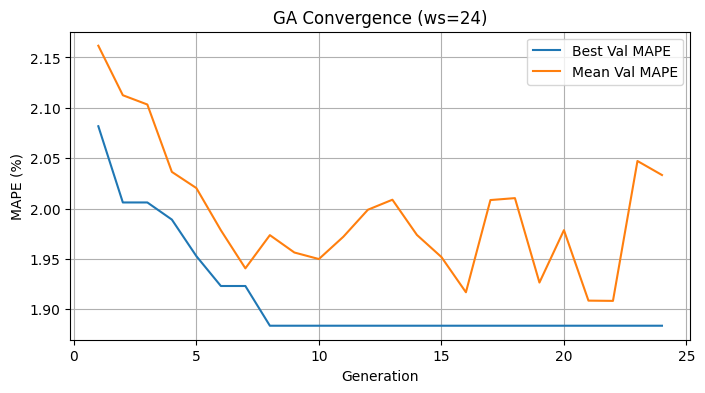

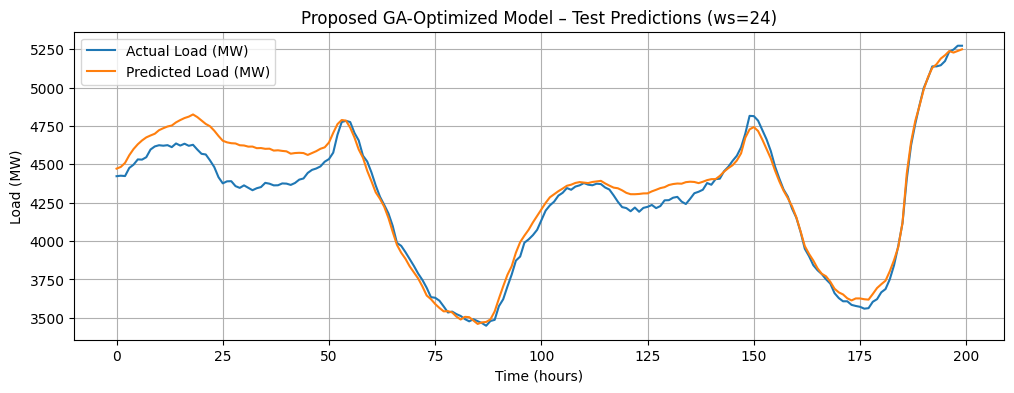

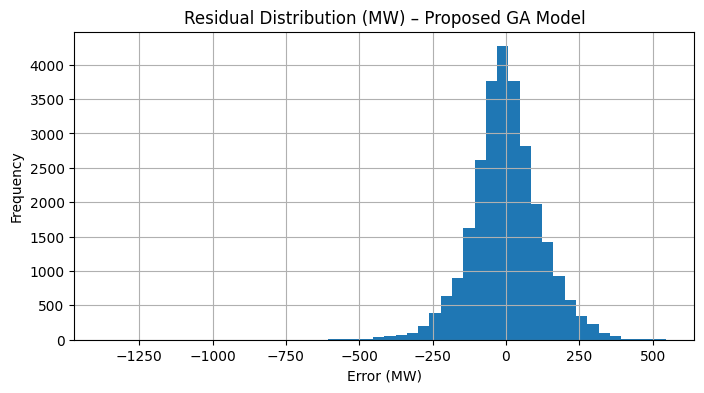

Saved plots to: /content/drive/MyDrive/dl_project/results/plots


In [43]:
import matplotlib.pyplot as plt

gens = [d["generation"] for d in ga_log]
best_mape = [d["best_val_mape"] for d in ga_log]
mean_mape = [d["mean_val_mape"] for d in ga_log]

plt.figure(figsize=(8,4))
plt.plot(gens, best_mape, label="Best Val MAPE")
plt.plot(gens, mean_mape, label="Mean Val MAPE")
plt.xlabel("Generation")
plt.ylabel("MAPE (%)")
plt.title(f"GA Convergence (ws={WS})")
plt.grid(True)
plt.legend()
plt.show()

N = 200
plt.figure(figsize=(12,4))
plt.plot(y_true_mw[:N], label="Actual Load (MW)")
plt.plot(y_pred_mw[:N], label="Predicted Load (MW)")
plt.title(f"Proposed GA-Optimized Model – Test Predictions (ws={WS})")
plt.xlabel("Time (hours)")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.legend()
plt.show()

res = y_true_mw - y_pred_mw
plt.figure(figsize=(8,4))
plt.hist(res, bins=50)
plt.title("Residual Distribution (MW) – Proposed GA Model")
plt.xlabel("Error (MW)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

PLOT_DIR = "/content/drive/MyDrive/dl_project/results/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

plt.figure(figsize=(8,4))
plt.plot(gens, best_mape, label="Best Val MAPE")
plt.plot(gens, mean_mape, label="Mean Val MAPE")
plt.xlabel("Generation")
plt.ylabel("MAPE (scaled space)")
plt.title(f"GA Convergence (ws={WS})")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, f"ga_convergence_ws{WS}.png"), dpi=300)
plt.close()

plt.figure(figsize=(12,4))
plt.plot(y_true_mw[:N], label="Actual Load (MW)")
plt.plot(y_pred_mw[:N], label="Predicted Load (MW)")
plt.title(f"Proposed GA-Optimized Model – Test Predictions (ws={WS})")
plt.xlabel("Time (hours)")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, f"proposed_ga_predictions_ws{WS}.png"), dpi=300)
plt.close()

plt.figure(figsize=(8,4))
plt.hist(res, bins=50)
plt.title("Residual Distribution (MW) – Proposed GA Model")
plt.xlabel("Error (MW)")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig(os.path.join(PLOT_DIR, f"proposed_ga_residuals_ws{WS}.png"), dpi=300)
plt.close()

print("Saved plots to:", PLOT_DIR)

In [44]:
import pandas as pd
from sklearn.metrics import r2_score

y_test = pd.Series(y_true_mw)
y_test_pred = pd.Series(y_pred_mw)

test_r2 = r2_score(y_test, y_test_pred)

start_datetime = pd.Timestamp("2019-01-01", tz="UTC")

df_viz = pd.DataFrame({
    "datetime": pd.date_range(
        start=start_datetime,
        periods=len(y_test),
        freq="H"
    ),
    "Actual": y_test.values,
    "Predicted": y_test_pred.values
})

df_viz["Hour"] = df_viz["datetime"].dt.hour
df_viz["IsWeekend"] = df_viz["datetime"].dt.dayofweek >= 5
df_viz["Month"] = df_viz["datetime"].dt.month

def season_map(m):
    if m in [12, 1, 2]: return "Winter"
    if m in [3, 4, 5]: return "Spring"
    if m in [6, 7, 8]: return "Summer"
    return "Autumn"

df_viz["Season"] = df_viz["Month"].apply(season_map)

print("df_viz ready:", df_viz.head())


df_viz ready:                    datetime       Actual    Predicted  Hour  IsWeekend  Month  \
0 2019-01-01 00:00:00+00:00  4422.700195  4471.883789     0      False      1   
1 2019-01-01 01:00:00+00:00  4425.850098  4483.072266     1      False      1   
2 2019-01-01 02:00:00+00:00  4423.629883  4509.373535     2      False      1   
3 2019-01-01 03:00:00+00:00  4476.540039  4559.430664     3      False      1   
4 2019-01-01 04:00:00+00:00  4497.810059  4599.492188     4      False      1   

   Season  
0  Winter  
1  Winter  
2  Winter  
3  Winter  
4  Winter  


/tmp/ipython-input-1717304534.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "datetime": pd.date_range(


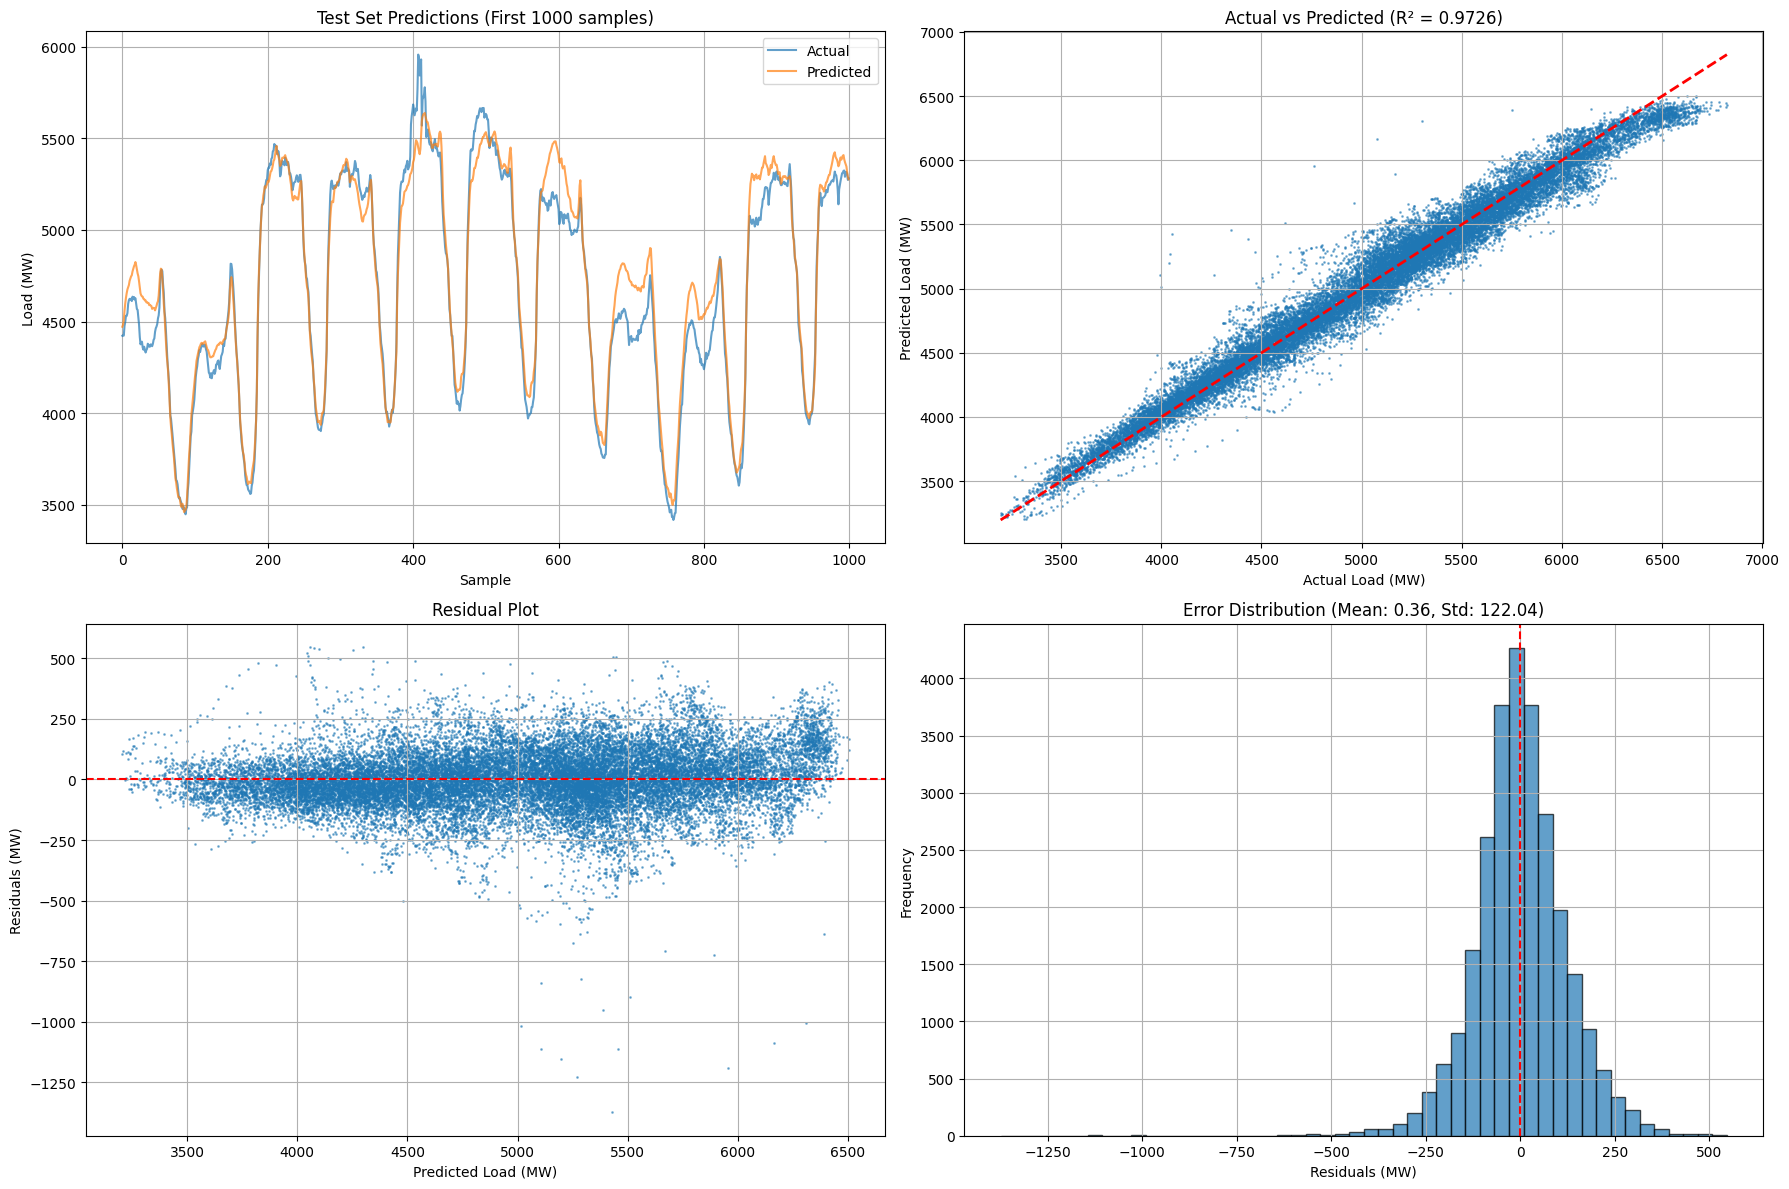

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sample_size = min(1000, len(y_test))
axes[0, 0].plot(y_test.values[:sample_size], label='Actual', alpha=0.7)
axes[0, 0].plot(y_test_pred.values[:sample_size], label='Predicted', alpha=0.7)
axes[0, 0].set_title(f'Test Set Predictions (First {sample_size} samples)')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Load (MW)')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, s=1)
axes[0, 1].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', lw=2
)
axes[0, 1].set_xlabel('Actual Load (MW)')
axes[0, 1].set_ylabel('Predicted Load (MW)')
axes[0, 1].set_title(f'Actual vs Predicted (R² = {test_r2:.4f})')
axes[0, 1].grid(True)

residuals = y_test - y_test_pred
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.5, s=1)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Load (MW)')
axes[1, 0].set_ylabel('Residuals (MW)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True)

axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Residuals (MW)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(
    f'Error Distribution (Mean: {residuals.mean():.2f}, Std: {residuals.std():.2f})'
)
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/dl_project/results/plots/test_predictions.png', dpi=300)
plt.show()


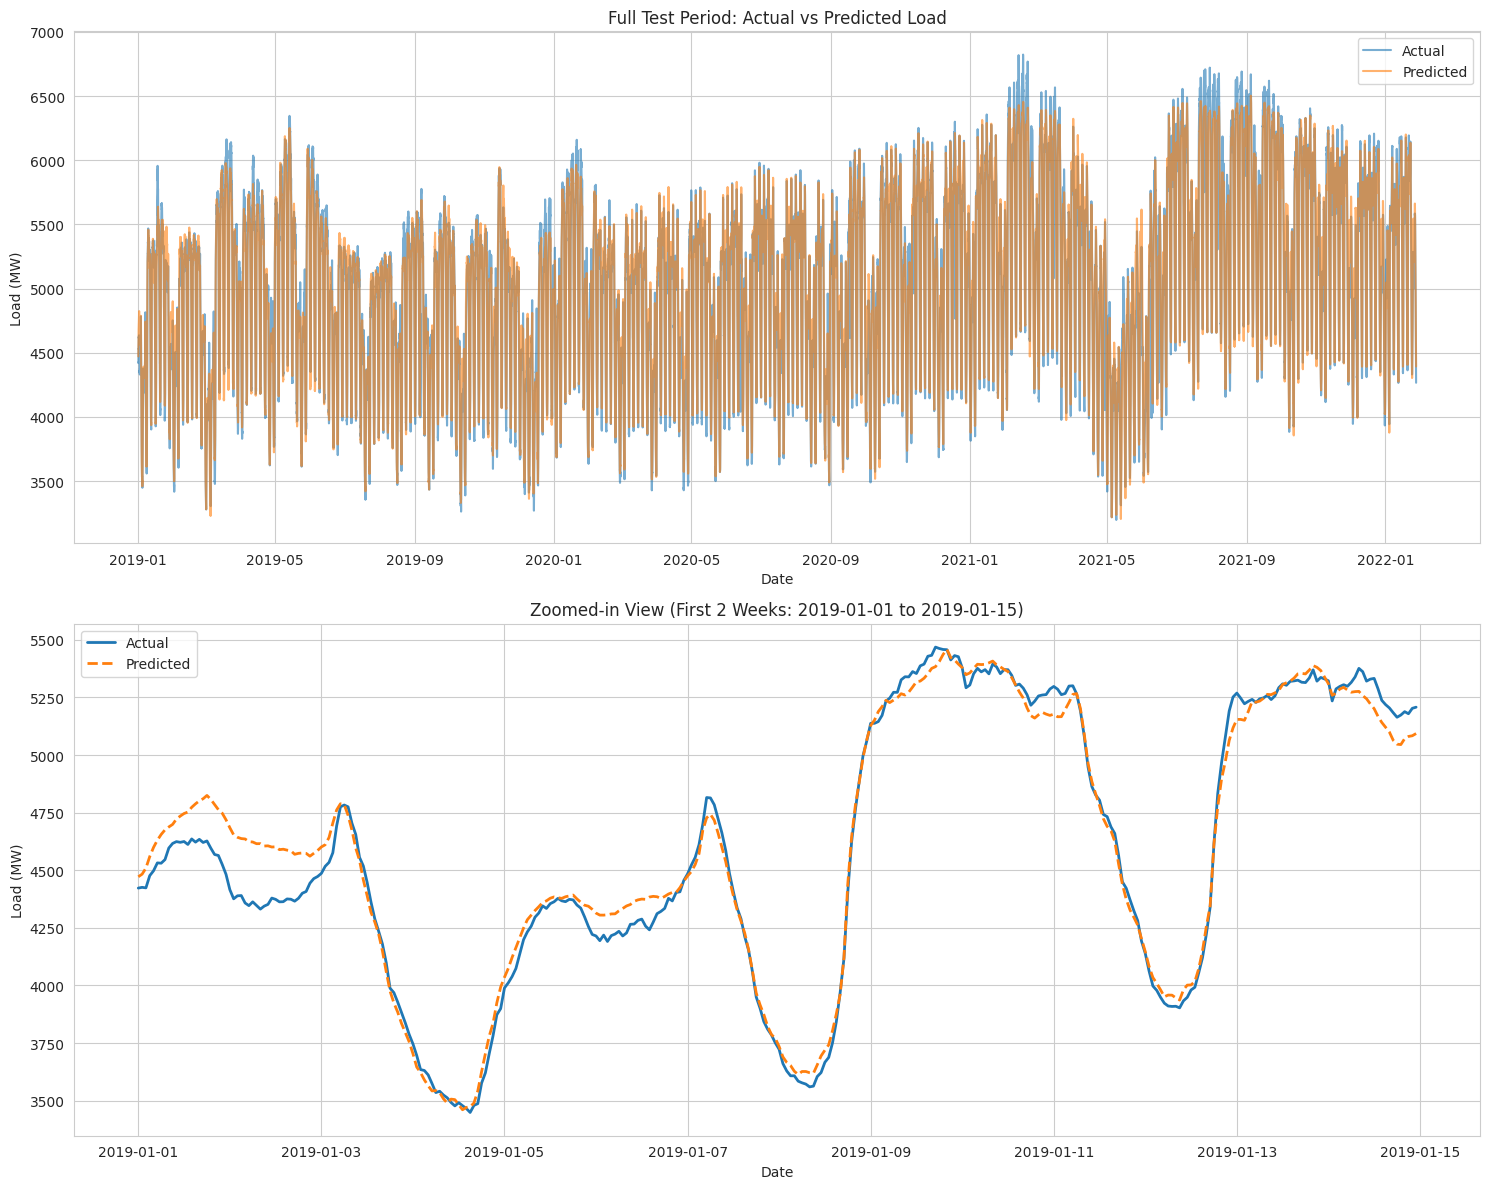

In [46]:
import seaborn as sns
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

axes[0].plot(df_viz['datetime'], df_viz['Actual'], label='Actual', alpha=0.6)
axes[0].plot(df_viz['datetime'], df_viz['Predicted'], label='Predicted', alpha=0.6)
axes[0].set_title('Full Test Period: Actual vs Predicted Load')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

zoom_start = df_viz['datetime'].min()
zoom_end = zoom_start + pd.Timedelta(days=14)
df_zoom = df_viz[
    (df_viz['datetime'] >= zoom_start) &
    (df_viz['datetime'] < zoom_end)
]

axes[1].plot(df_zoom['datetime'], df_zoom['Actual'], label='Actual', linewidth=2)
axes[1].plot(df_zoom['datetime'], df_zoom['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[1].set_title(
    f'Zoomed-in View (First 2 Weeks: {zoom_start.date()} to {zoom_end.date()})'
)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Load (MW)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/dl_project/results/plots/time_series_comparison.png', dpi=300)
plt.show()


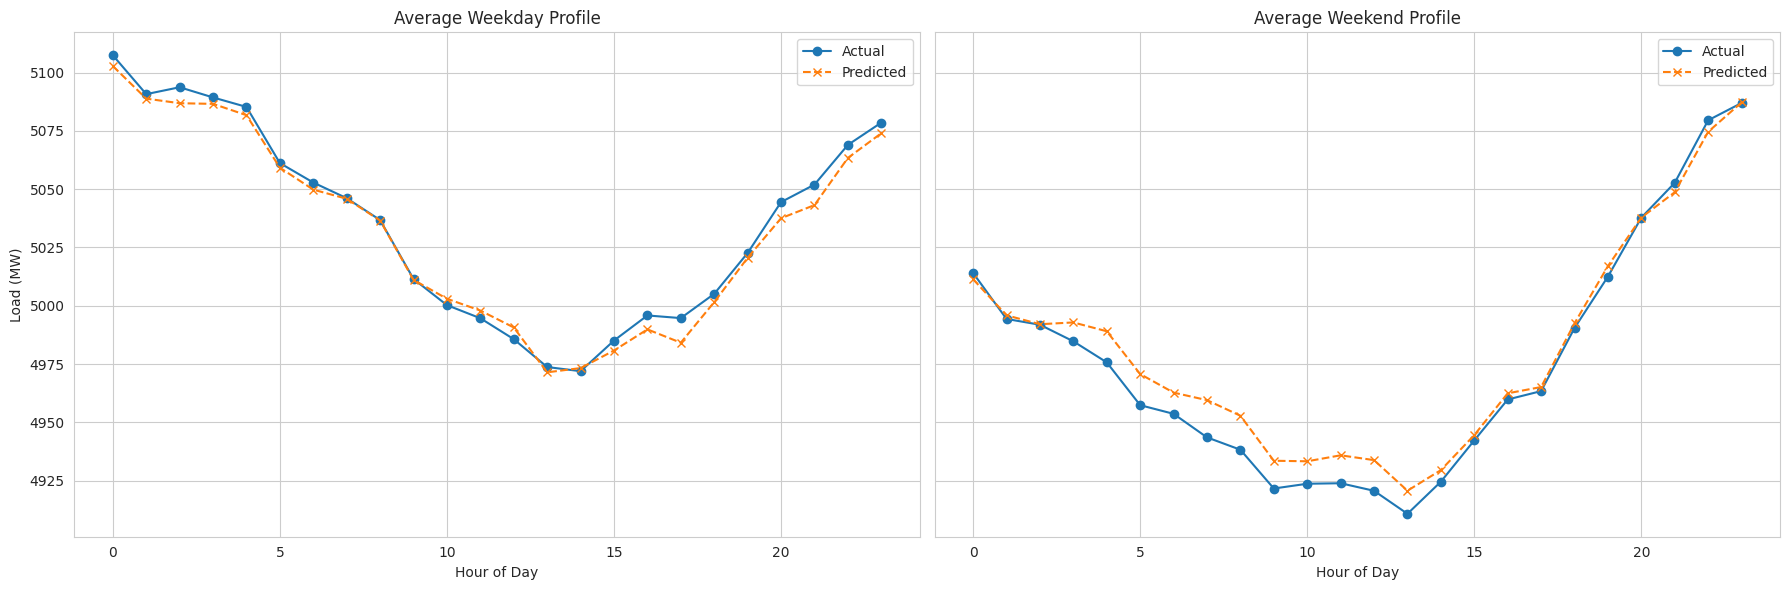

In [47]:
weekday_df = df_viz[~df_viz['IsWeekend']]
weekend_df = df_viz[df_viz['IsWeekend']]

weekday_hourly = weekday_df.groupby('Hour')[['Actual', 'Predicted']].mean()
weekend_hourly = weekend_df.groupby('Hour')[['Actual', 'Predicted']].mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

axes[0].plot(weekday_hourly.index, weekday_hourly['Actual'], marker='o', label='Actual')
axes[0].plot(weekday_hourly.index, weekday_hourly['Predicted'], marker='x', linestyle='--', label='Predicted')
axes[0].set_title('Average Weekday Profile')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(weekend_hourly.index, weekend_hourly['Actual'], marker='o', label='Actual')
axes[1].plot(weekend_hourly.index, weekend_hourly['Predicted'], marker='x', linestyle='--', label='Predicted')
axes[1].set_title('Average Weekend Profile')
axes[1].set_xlabel('Hour of Day')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/dl_project/results/plots/weekday_weekend_profiles.png', dpi=300)
plt.show()
